In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from tqdm import tqdm
import os

In [1]:
import wandb

In [2]:
!wandb login 6001619563748a57b4114b0bb090fd4129ba6122

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from tqdm import tqdm
import os
import wandb  # Import wandb

In [5]:
# Initialize wandb with configuration
config = {
    'batch_size': 32,
    'epochs': 15,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'dropout_rate': 0.5,
    'classifier_hidden_units': 512,
    'scheduler_factor': 0.1,
    'scheduler_patience': 2,
    'model_architecture': 'resnet50',
    'pretrained': True,
    'optimizer': 'AdamW',
    'loss_function': 'CrossEntropyLoss'
}

wandb.init(project="inaturalist-classification", config=config)

In [20]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize wandb with configuration
config = {
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'dropout_rate': 0.5,
    'classifier_hidden_units': 512,
    'scheduler_factor': 0.1,
    'scheduler_patience': 2,
    'model_architecture': 'resnet50',
    'pretrained': True,
    'optimizer': 'AdamW',
    'loss_function': 'CrossEntropyLoss'
}

wandb.init(project="inaturalist-classification", config=config)

wandb: Currently logged in as: cs24m025 (manglesh-patidar-cs24m025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [11]:

# Data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:


def get_dataset_and_loaders(data_dir, train_transform, val_transform, batch_size=32, val_split=0.2):
    full_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    
    # Create stratified split
    targets = np.array(full_dataset.targets)
    train_indices, val_indices = [], []
    
    for class_idx in np.unique(targets):
        class_indices = np.where(targets == class_idx)[0]
        n_val = int(len(class_indices) * val_split)
        np.random.shuffle(class_indices)
        val_indices.extend(class_indices[:n_val])
        train_indices.extend(class_indices[n_val:])
    
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    
    # Apply different transform to validation set
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, full_dataset.classes

In [19]:

# Load pre-trained model and modify classifier
def create_model(num_classes=10):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
        
    # Modify the classifier using config values
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(config['dropout_rate']),
        nn.Linear(num_features, config['classifier_hidden_units']),
        nn.ReLU(),
        nn.Linear(config['classifier_hidden_units'], num_classes))
    
    # Unfreeze classifier parameters
    for param in model.fc.parameters():
        param.requires_grad = True
        
    return model.to(device)

In [21]:

# Initialize model, dataloaders, and optimizer
train_loader, val_loader, classes = get_dataset_and_loaders(
    '/kaggle/input/naturalist/inaturalist_12K',
    train_transform,
    val_transform,
    batch_size=config['batch_size']
)

model = create_model(num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience']
)

In [22]:


# Watch model with wandb
wandb.watch(model, log_freq=100, log="all")

In [20]:


# Training loop
best_val_acc = 0.0
for epoch in range(config['epochs']):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    
    # Update learning rate
    #scheduler.step(val_acc)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    # Print metrics
    print(f"Epoch {epoch+1}/{config['epochs']}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        wandb.save('best_model.pth')  # Save model to wandb
        print(f"New best model saved with val acc: {best_val_acc:.4f}")
        wandb.run.summary["best_val_accuracy"] = best_val_acc  # Update summary

print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")
wandb.finish()

Epoch 1 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch 1/10:
Train Loss: 0.2700 | Acc: 0.9099
Val Loss: 0.5230 | Acc: 0.8484
LR: 1.00e-04
New best model saved with val acc: 0.8484


Epoch 2 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]


Epoch 2/10:
Train Loss: 0.2672 | Acc: 0.9115
Val Loss: 0.5256 | Acc: 0.8484
LR: 1.00e-04


Epoch 3 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch 3/10:
Train Loss: 0.2713 | Acc: 0.9064
Val Loss: 0.5418 | Acc: 0.8449
LR: 1.00e-04


Epoch 4 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Epoch 4/10:
Train Loss: 0.2603 | Acc: 0.9127
Val Loss: 0.5303 | Acc: 0.8454
LR: 1.00e-04


Epoch 5 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch 5/10:
Train Loss: 0.2541 | Acc: 0.9156
Val Loss: 0.5419 | Acc: 0.8424
LR: 1.00e-04


Epoch 6 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]


Epoch 6/10:
Train Loss: 0.2545 | Acc: 0.9166
Val Loss: 0.5117 | Acc: 0.8489
LR: 1.00e-04
New best model saved with val acc: 0.8489


Epoch 7 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.71it/s]


Epoch 7/10:
Train Loss: 0.2533 | Acc: 0.9171
Val Loss: 0.5381 | Acc: 0.8404
LR: 1.00e-04


Epoch 8 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


Epoch 8/10:
Train Loss: 0.2425 | Acc: 0.9184
Val Loss: 0.5229 | Acc: 0.8499
LR: 1.00e-04
New best model saved with val acc: 0.8499


Epoch 9 [Val]: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch 9/10:
Train Loss: 0.2480 | Acc: 0.9169
Val Loss: 0.5496 | Acc: 0.8439
LR: 1.00e-04


Epoch 10 [Val]: 100%|██████████| 63/63 [00:12<00:00,  5.20it/s]

Epoch 10/10:
Train Loss: 0.2453 | Acc: 0.9199
Val Loss: 0.5419 | Acc: 0.8479
LR: 1.00e-04
Training complete. Best validation accuracy: 0.8499


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▃▄▁▄▆▆▇▇▆█
train_loss,█▇█▅▄▄▄▁▂▂
val_accuracy,▇▇▄▅▂▇▁█▄▇
val_loss,▃▄▇▄▇▁▆▃█▇
best_val_accuracy,0.84992
epoch,9
learning_rate,0.0001
train_accuracy,0.91987
train_loss,0.24531


In [23]:


# Training loop
best_val_acc = 0.0
for epoch in range(config['epochs']):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    
    # Update learning rate
    #scheduler.step(val_acc)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    # Print metrics
    print(f"Epoch {epoch+1}/{config['epochs']}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        wandb.save('best_model.pth')  # Save model to wandb
        print(f"New best model saved with val acc: {best_val_acc:.4f}")
        wandb.run.summary["best_val_accuracy"] = best_val_acc  # Update summary

print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")
wandb.finish()

Epoch 1 [Val]: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Epoch 1/20:
Train Loss: 1.0490 | Acc: 0.6741
Val Loss: 0.6374 | Acc: 0.8134
LR: 1.00e-03
New best model saved with val acc: 0.8134


Epoch 2 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Epoch 2/20:
Train Loss: 0.7272 | Acc: 0.7658
Val Loss: 0.5842 | Acc: 0.8229
LR: 1.00e-03
New best model saved with val acc: 0.8229


Epoch 3 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Epoch 3/20:
Train Loss: 0.6407 | Acc: 0.7914
Val Loss: 0.5728 | Acc: 0.8219
LR: 1.00e-03


Epoch 4 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Epoch 4/20:
Train Loss: 0.5906 | Acc: 0.8030
Val Loss: 0.5305 | Acc: 0.8389
LR: 1.00e-03
New best model saved with val acc: 0.8389


Epoch 5 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Epoch 5/20:
Train Loss: 0.5417 | Acc: 0.8179
Val Loss: 0.5346 | Acc: 0.8369
LR: 1.00e-03


Epoch 6 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Epoch 6/20:
Train Loss: 0.5104 | Acc: 0.8246
Val Loss: 0.5221 | Acc: 0.8409
LR: 1.00e-03
New best model saved with val acc: 0.8409


Epoch 7 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Epoch 7/20:
Train Loss: 0.4752 | Acc: 0.8390
Val Loss: 0.5181 | Acc: 0.8449
LR: 1.00e-03
New best model saved with val acc: 0.8449


Epoch 8 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch 8/20:
Train Loss: 0.4531 | Acc: 0.8459
Val Loss: 0.5163 | Acc: 0.8374
LR: 1.00e-03


Epoch 9 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


Epoch 9/20:
Train Loss: 0.4251 | Acc: 0.8550
Val Loss: 0.5111 | Acc: 0.8434
LR: 1.00e-03


Epoch 10 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Epoch 10/20:
Train Loss: 0.3893 | Acc: 0.8620
Val Loss: 0.5309 | Acc: 0.8319
LR: 1.00e-03


Epoch 11 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


Epoch 11/20:
Train Loss: 0.3622 | Acc: 0.8718
Val Loss: 0.5084 | Acc: 0.8434
LR: 1.00e-03


Epoch 12 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Epoch 12/20:
Train Loss: 0.3376 | Acc: 0.8862
Val Loss: 0.5315 | Acc: 0.8374
LR: 1.00e-03


Epoch 13 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Epoch 13/20:
Train Loss: 0.3026 | Acc: 0.8948
Val Loss: 0.5258 | Acc: 0.8389
LR: 1.00e-03


Epoch 14 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Epoch 14/20:
Train Loss: 0.3046 | Acc: 0.8962
Val Loss: 0.5347 | Acc: 0.8359
LR: 1.00e-03


Epoch 15 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Epoch 15/20:
Train Loss: 0.2704 | Acc: 0.9100
Val Loss: 0.5279 | Acc: 0.8409
LR: 1.00e-03


Epoch 16 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Epoch 16/20:
Train Loss: 0.2359 | Acc: 0.9189
Val Loss: 0.5399 | Acc: 0.8434
LR: 1.00e-03


Epoch 17 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Epoch 17/20:
Train Loss: 0.2274 | Acc: 0.9233
Val Loss: 0.5497 | Acc: 0.8364
LR: 1.00e-03


Epoch 18 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Epoch 18/20:
Train Loss: 0.2132 | Acc: 0.9255
Val Loss: 0.5372 | Acc: 0.8484
LR: 1.00e-03
New best model saved with val acc: 0.8484


Epoch 19 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Epoch 19/20:
Train Loss: 0.2157 | Acc: 0.9245
Val Loss: 0.5514 | Acc: 0.8364
LR: 1.00e-03


Epoch 20 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

Epoch 20/20:
Train Loss: 0.1833 | Acc: 0.9385
Val Loss: 0.5514 | Acc: 0.8449
LR: 1.00e-03
Training complete. Best validation accuracy: 0.8484


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▃▆▆▇▇▆▇▅▇▆▆▅▇▇▆█▆▇
val_loss,█▅▄▂▂▂▂▁▁▂▁▂▂▂▂▃▃▃▃▃
best_val_accuracy,0.84842
epoch,19
learning_rate,0.001
train_accuracy,0.9385
train_loss,0.18329


In [15]:
wandb.init(project="inaturalist-classification", config=config)

In [16]:
# Load the best model for testing
best_model = create_model(num_classes=len(classes))
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

# Test data transformations (should match validation transforms)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = ImageFolder(
    os.path.join('/kaggle/input/naturalist/inaturalist_12K', 'val'),  # or 'test' if available
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Test evaluation
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total

# Log test results to wandb
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc
})

# Print test results
print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

# Log confusion matrix
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_labels,
        preds=all_preds,
        class_names=classes)
})

# Optionally: Log per-class metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
wandb.log({"classification_report": report})
print(classification_report(all_labels, all_preds, target_names=classes))

wandb.finish()

/tmp/ipykernel_31/3806938889.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))
Testing: 100%|██████████| 63/63 [00


Test Results:
Loss: 0.4687 | Accuracy: 0.8570

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.87      0.87      0.87       200
    Animalia       0.83      0.81      0.82       200
   Arachnida       0.93      0.83      0.88       200
        Aves       0.93      0.92      0.92       200
       Fungi       0.87      0.87      0.87       200
     Insecta       0.88      0.82      0.85       200
    Mammalia       0.81      0.92      0.86       200
    Mollusca       0.84      0.81      0.82       200
     Plantae       0.77      0.88      0.82       200
    Reptilia       0.86      0.85      0.86       200

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



test_accuracy,▁
test_loss,▁
test_accuracy,0.857
test_loss,0.46867


In [25]:
wandb.init(project="inaturalist-classification", config=config)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


### **1. Generate Confusion Matrix**
cm = confusion_matrix(all_labels, all_preds)

### **2. Plot Confusion Matrix**
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

### **3. Save the Plot**
cm_path = "confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()

### **4. Log to WandB**
wandb.log({
    "confusion_matrix": wandb.Image(cm_path),
    "conf_mat": wandb.plot.confusion_matrix(  # Also log interactive version
        y_true=all_labels,
        preds=all_preds,
        class_names=classes)
})

# Log classification report
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
wandb.log({"classification_report": report})
print(classification_report(all_labels, all_preds, target_names=classes))

wandb.finish()

              precision    recall  f1-score   support

    Amphibia       0.87      0.87      0.87       200
    Animalia       0.83      0.81      0.82       200
   Arachnida       0.93      0.83      0.88       200
        Aves       0.93      0.92      0.92       200
       Fungi       0.87      0.87      0.87       200
     Insecta       0.88      0.82      0.85       200
    Mammalia       0.81      0.92      0.86       200
    Mollusca       0.84      0.81      0.82       200
     Plantae       0.77      0.88      0.82       200
    Reptilia       0.86      0.85      0.86       200

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



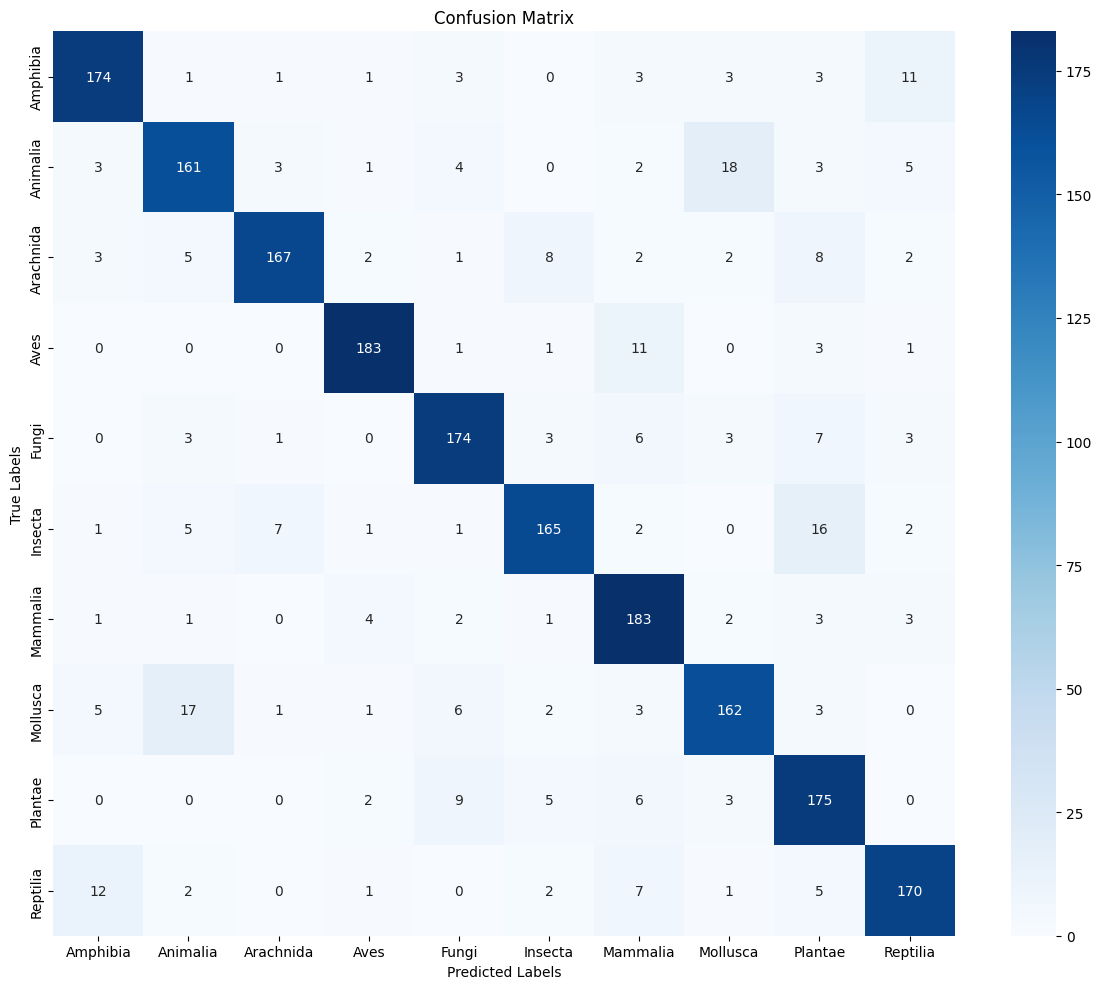

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

# Display confusion matrix in notebook
plt.show()

# Save the figure
cm_image_path = "confusion_matrix.png"
fig.savefig(cm_image_path)

# Log confusion matrix image to W&B
wandb.log({"confusion_matrix_image": wandb.Image(cm_image_path)})
